# 1. Load the model

In [2]:
import os
import time
import pypianoroll
from pypianoroll import Multitrack, Track
import torch.utils.data as Data
from matplotlib import pyplot as plt
from vae_rnn import *

run on GPU


In [3]:
# list the models
path = os.getcwd() + '/models/all/'
models = [ m for m in os.listdir(path) if '.pt' in m ]

for i, m in enumerate(models):
    print('[{}]: {}'.format(i, m))

[0]: vae_L1E-02_beta2E+01_beat48_loss2E+01_tanh_gru16_e100_b256_20181005_180256.pt
[1]: vae_L1E-02_beta2E+01_beat48_loss2E+01_tanh_gru32_e100_b256_hd64-32_20181008_034323.pt
[2]: vae_L1E-02_beta2E+01_beat48_loss3E+01_tanh_gru256_e50_b256_hd64-32_20181005_211254.pt


In [4]:
encoder = Encoder().to(device)
decoder = Decoder(beat=48).to(device)
vae = VAE(encoder, decoder).to(device)

In [5]:
vae.load_state_dict(torch.load(path + models[1]))

In [6]:
for f in os.listdir('./../explore_data/data/'):
    print(f)

train_x_drum_reduced_World.npy
train_x_drum_reduced_Country.npy
train_x_drum_reduced_Punk.npy
train_x_drum_reduced_Folk.npy
train_x_drum_reduced_Pop.npy
train_x_drum_reduced_New-Age.npy
train_x_drum_reduced_Rock.npy
train_x_drum_reduced_Metal.npy
train_x_drum_reduced_Latin.npy
train_x_drum_reduced_Blues.npy
train_x_drum_reduced_Electronic.npy
train_x_drum_reduced_RnB.npy
.ipynb_checkpoints
train_x_drum_reduced_Rap.npy
train_x_drum_reduced_Reggae.npy
all
others
train_x_drum_reduced_Jazz.npy


In [7]:
def writeData2Midi(data, f='interpolation'):
    
    t = time.strftime("-%Y%m%d-%H%M%S")
    filename = f + t + '.mid'
    # filename = f + '.mid'
    filepath = './outputs/' + filename
    
    track = np.append(data, np.zeros((data.shape[0], 119)), axis=1)
    track = track * 128
    track = Track(pianoroll=track, program=0, is_drum=True)
    mt = Multitrack(
        tracks=[track],
        tempo=80.0,
        beat_resolution=24,
    )
    
    pypianoroll.write(mt, filepath)

In [8]:
def parse_data(training_data):
    ratio = TESTING_RATIO
    T = int(training_data.shape[0]*ratio)
    
    train_x = training_data[:-T]
    test_x = training_data[-T:]

    train_x = torch.from_numpy(train_x).type(torch.FloatTensor)
    test_x = torch.from_numpy(test_x).type(torch.FloatTensor)
    
    return train_x, test_x

In [73]:
genres = [x for x in os.listdir('./../explore_data/data/') if '.npy' in x]
g = genres[4]
print(g)
train_x_reduced = np.load('./../explore_data/data/' + g)
print(train_x_reduced.shape)

TESTING_RATIO = 0.05
N_DATA = train_x_reduced.shape[0]
N_TRAINING = int(train_x_reduced.shape[0]*TESTING_RATIO)
N_TESTING = N_DATA - N_TRAINING

train_x, test_x = parse_data(train_x_reduced)
train_dataset = Data.TensorDataset(train_x)
test_dataset = Data.TensorDataset(test_x)

train_loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=1,
)
test_loader = Data.DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=1,
)

train_x_drum_reduced_Pop.npy
(98647, 96, 9)


In [10]:
def slerp(a, b, steps=256):
    aa =  np.squeeze(a/np.linalg.norm(a))
    bb =  np.squeeze(b/np.linalg.norm(b))
    ttt = np.sum(aa*bb)
    omega = np.arccos(ttt)
    so = np.sin(omega)
    step_deg = 1 / (steps+1)
    step_list = []

    for idx in range(1, steps+1):
        t = step_deg*idx
        tmp = np.sin((1.0-t)*omega) / so * a + np.sin(t*omega)/so * b
        step_list.append(tmp)
    return step_list

In [11]:
# read midi
def parseMidi(filename):
    mt = pypianoroll.parse(filename)
    track = mt.tracks[0]
    pr = track.pianoroll
    pr = np.where(pr > 0, 1, 0)
    pr = pr[:,:9]
    return pr


# 2.2 Evaluation using train set

torch.Size([256, 96, 9])
tensor([ 0.0031, -0.0032, -0.0460,  0.0196, -0.0160, -0.0457, -0.0159, -0.0394,
         0.0094, -0.0135,  0.0475, -0.0323,  0.0447, -0.0042, -0.0360, -0.0135,
        -0.0088, -0.0232,  0.0011,  0.0386, -0.0002,  0.0238, -0.0256, -0.0065,
         0.0184,  0.0508, -0.0153,  0.0407,  0.0407,  0.0141, -0.0379, -0.0269],
       device='cuda:0')
dist[1]: 0.21478477120399475
dist[2]: 0.1934613287448883
dist[3]: 0.24613146483898163
dist[4]: 0.2618453800678253
dist[5]: 0.1997235268354416
dist[6]: 0.280394971370697
dist[7]: 0.0
dist[8]: 0.2831821143627167


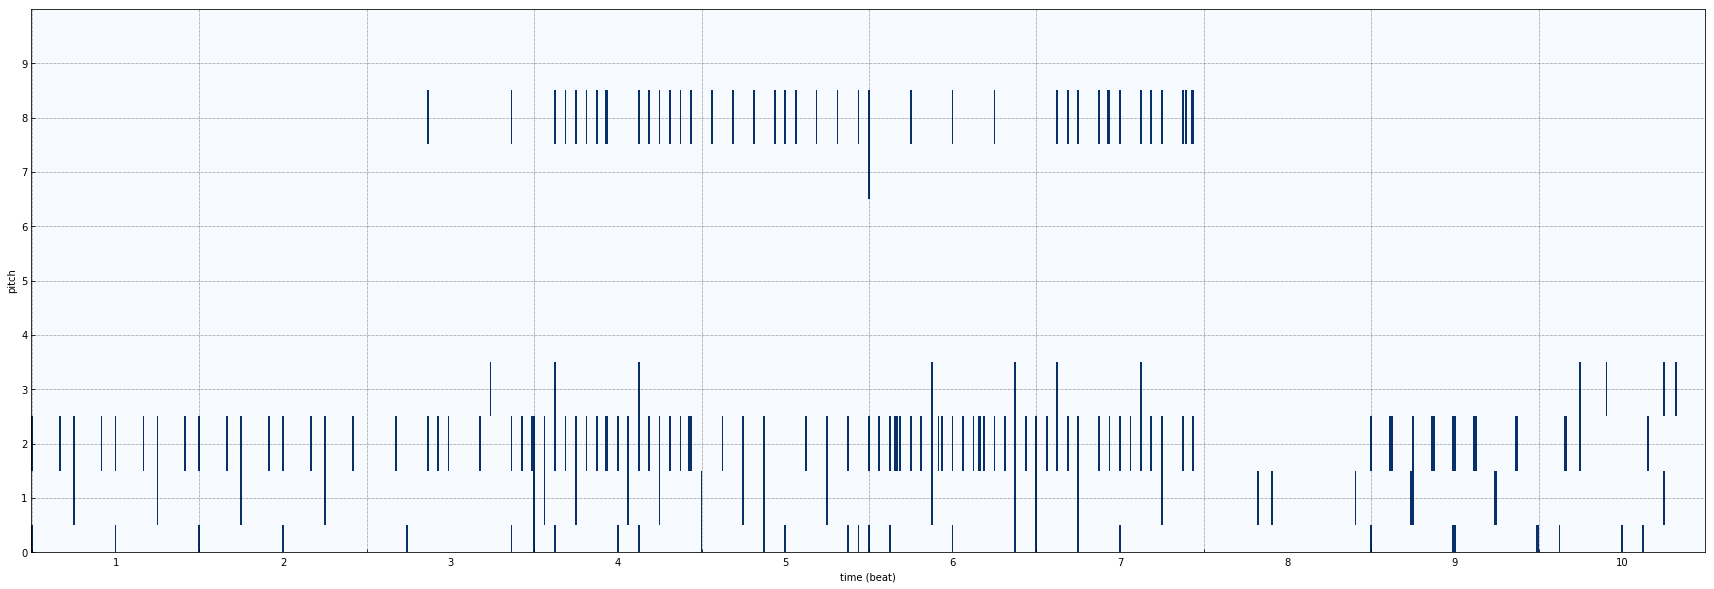

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f77fd8239e8>>
Traceback (most recent call last):
  File "/home/vibertthio/.pyenv/versions/drum-vae/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/vibertthio/.pyenv/versions/drum-vae/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 345, in get
    return ForkingPickler.loads(res)
  File "/home/vibertthio/.pyenv/versions/drum-vae/lib/python3.5/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.5/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.5/multiprocessing/resource_sharer.py", line 87

In [29]:
for batch_i, data in enumerate(train_loader):
    with torch.no_grad():
        data = data[0]
        # pltReducedDrumTrack(data[0])
        # pltReducedDrumTrack(data[1])

        data = Variable(data).type(torch.float32).to(device)
        latent = vae._enc_mu(encoder(data))
        print(latent[0])
        out = decoder(latent)
        out_np = out.cpu().data.numpy()
        out_np = np.where(out_np > 0.2, 128, 0)

        out_concat = np.empty((0, 9))
        out_concat = np.concatenate(
            (out_concat, data[0]),
            axis=0)
        out_concat = np.concatenate(
            (out_concat, out_np[0]),
            axis=0)

        for i in range(8):
            dist = np.linalg.norm(
                latent[0].cpu().data.numpy() - latent[i+1].cpu().data.numpy())
            print('dist[{}]: {}'.format(i+1, dist))
            steps = np.asarray(slerp(
                latent[0].cpu().data.numpy(),
                latent[i+1].cpu().data.numpy(),
            ))
            steps = torch.from_numpy(steps).to(device)
            steps_out = decoder(steps)


            o = steps_out[8].cpu().data.numpy()
            o = np.where(o > 0.5, 128, 0)
            out_concat = np.concatenate(
                (out_concat, o),
                axis=0)

        writeData2Midi(out_concat)
        pltReducedDrumTrack(
            out_concat,
            beat_resolution=96,
        )
    break


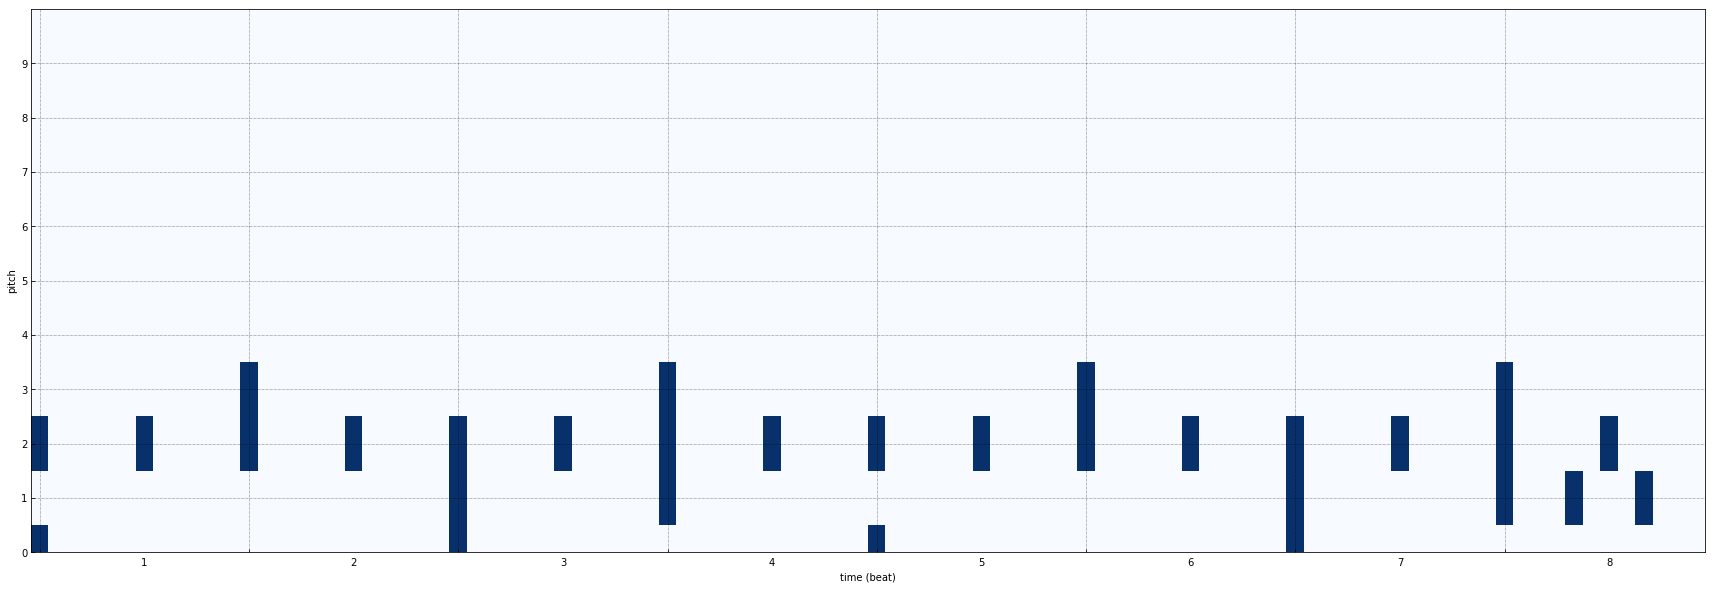

(-1, -1)
(0, -1)
(1, -1)
(-1, 0)
(0, 0)
(1, 0)
(-1, 1)
(0, 1)
(1, 1)


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f78105c47b8>>
Traceback (most recent call last):
  File "/home/vibertthio/.pyenv/versions/drum-vae/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/vibertthio/.pyenv/versions/drum-vae/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 345, in get
    return ForkingPickler.loads(res)
  File "/home/vibertthio/.pyenv/versions/drum-vae/lib/python3.5/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.5/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.5/multiprocessing/reduction.py", line 181, in recv_handle
    retur

In [80]:
for batch_i, data in enumerate(train_loader):
    with torch.no_grad():
        data = data[0]
        pltReducedDrumTrack(data[0])
        # pltReducedDrumTrack(data[1])

        data = Variable(data).type(torch.float32).to(device)
        latent = vae._enc_mu(encoder(data))
        out = decoder(latent)
        out_np = out.cpu().data.numpy()
        out_np = np.where(out_np > 0.2, 128, 0)

        out_concat = np.concatenate(
            (out_concat, out_np[0]),
            axis=0)

        for i in range(9):
            x = i % 3 - 1
            y = i // 3 - 1
            print('({}, {})'.format(x, y))
            
            latent_shift = latent.cpu().data.numpy()
            shift = np.zeros(latent_shift.shape, dtype=np.float32)
            shift[0][2] = x * 0.2
            shift[0][3] = y * 0.2
            latent_shift = latent_shift + shift

            latent_shift = torch.from_numpy(latent_shift).to(device)
            o = decoder(latent_shift)

            o = o[0].cpu().data.numpy()
            o = np.where(o > 0.5, 128, 0)
            writeData2Midi(o, '{}_{}'.format(x, y))

    break
